# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


---
### Why We're Here 

In this notebook, We will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of our finished project.

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets


* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  


In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [19]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  


Number of faces detected: 1


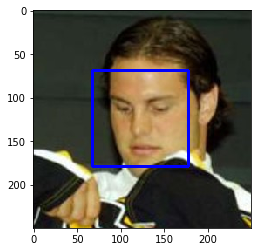

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below. 

In [5]:

# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`. 

__Answer:__ 

######   haarcascade_frontalface_alt
* Face Detector Accuracy on Human images : 99.0%
* Face Detector Accuracy on dog images : 9.0%

######  FaceNet pytorch
* Face Detector Accuracy on Human images using DL : 100.0%
* Face Detector Accuracy on dog images using DL : 20.0% 

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


human_face_human_img_count = 0
for human_img in tqdm(human_files_short):
    human_face_human_img_count += int(face_detector(human_img))

human_face_dog_img_count = 0
for dog_img in tqdm(dog_files_short):
    human_face_dog_img_count += int(face_detector(dog_img))
## on the images in human_files_short and dog_files_short.


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


In [5]:
print(f" Face Detector Accuracy on Human images : {human_face_human_img_count * 100/len(human_files_short)}%")
print(f" Face Detector Accuracy on dog images : {human_face_dog_img_count * 100/len(dog_files_short)}%")


 Face Detector Accuracy on Human images : 99.0%
 Face Detector Accuracy on dog images : 9.0%


In [6]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from facenet_pytorch import MTCNN
mtcnn = MTCNN(margin= 20, keep_all= True, post_process= False)

def face_detector_dl(img_path):
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes, probs = mtcnn.detect(rgb)
    return boxes is not None


In [7]:
human_face_human_img_count_dl = 0
for human_img in tqdm(human_files_short):
    human_face_human_img_count_dl += int(face_detector_dl(human_img))

human_face_dog_img_count_dl = 0
for dog_img in tqdm(dog_files_short):
    human_face_dog_img_count_dl += int(face_detector_dl(dog_img))

100%|██████████| 100/100 [00:13<00:00,  7.45it/s]


In [8]:
print(f" Face Detector Accuracy on Human images using DL : {human_face_human_img_count_dl * 100/len(human_files_short)}%")
print(f" Face Detector Accuracy on dog images using DL : {human_face_dog_img_count_dl * 100/len(dog_files_short)}%")


 Face Detector Accuracy on Human images using DL : 100.0%
 Face Detector Accuracy on dog images using DL : 20.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).   

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, we will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html). 

In [49]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image = Image.open(img_path).convert('RGB')

    preprocess = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

    img_tensor = preprocess(image)
    img_tensor = img_tensor.unsqueeze(0)

    VGG16.eval()
    with torch.no_grad():
        pred_prob = VGG16(img_tensor.to(device))
        pred_class = pred_prob.argmax(dim=1).item()
    
    return pred_class

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not). 

In [1]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    pred_class = VGG16_predict(img_path)
    return pred_class in range(151,269) # true/false

### Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

###### VGG16
* Dog Detector Accuracy on Human images using VGG16 : 1.0%
* Dog Detector Accuracy on dog images using VGG16 : 97.0%

###### ResNet50
* Dog Detector Accuracy on Human images using ResNet50 : 1.0%
* Dog Detector Accuracy on dog images using ResNet50 : 97.0%

###### Inception_v3
* Dog Detector Accuracy on Human images using Inception_v3 : 2.0%
* Dog Detector Accuracy on dog images using Inception_v3 : 95.0%

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`. 

In [13]:

from PIL import Image
import torchvision.transforms as transforms

def model_predict(img_path, model, input_size):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image = Image.open(img_path)
    
    preprocess = transforms.Compose([transforms.Resize(input_size), 
                                    transforms.CenterCrop(input_size), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    

    img_tensor = preprocess(image)
    img_tensor = img_tensor.unsqueeze(0)

    model.eval()
    with torch.no_grad():
        pred_prob = model(img_tensor.to(device))
        pred_class = pred_prob.argmax(dim=1).item()
    
    return pred_class

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_model(img_path, model, input_size):
    
    
    
    pred_class = model_predict(img_path, model, input_size)
    return pred_class in range(151,269) # true/false

def initialize_model(model_name):
    if model_name == "resnet":
        """ ResNet 50 """
        
        model = models.resnet50(pretrained=True)
        input_size = 224
        
    elif model_name == "vgg":
        """ VGG16 """
        
        model = models.vgg16(pretrained=True)
        input_size = 224
        
    elif model_name == "inception":
        """ Inception v3 """
        
        model = models.inception_v3(pretrained=True)
        input_size = 299
    else:
        print(f" model name is not recognized please, try again!!")
    
    if use_cuda:
        model = model.cuda()
        
    return model,input_size

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# model_name = "vgg"
for model_name in ["vgg","resnet","inception"]:
    print(f"Getting {model_name} ....")
    model, input_size = initialize_model(model_name)

    human_face_human_img_count_model = 0
    for human_img in tqdm(human_files_short):
        human_face_human_img_count_model += int(dog_detector_model(human_img, model, input_size))

    human_face_dog_img_count_model = 0
    for dog_img in tqdm(dog_files_short):
        human_face_dog_img_count_model += int(dog_detector_model(dog_img, model, input_size) and True)

    print(f" Dog Detector Accuracy on Human images using {model_name} : {human_face_human_img_count_model * 100/len(human_files_short)}%")
    print(f" Dog Detector Accuracy on dog images using {model_name} : {human_face_dog_img_count_model * 100/len(dog_files_short)}%")
    print(f" =====  ")

Getting vgg ....


100%|██████████| 100/100 [00:01<00:00, 72.03it/s]


 Dog Detector Accuracy on Human images using vgg : 1.0%
 Dog Detector Accuracy on dog images using vgg : 97.0%
 =====  
Getting resnet ....


100%|██████████| 100/100 [00:02<00:00, 47.46it/s]


 Dog Detector Accuracy on Human images using resnet : 1.0%
 Dog Detector Accuracy on dog images using resnet : 97.0%
 =====  
Getting inception ....


100%|██████████| 100/100 [00:03<00:00, 32.49it/s]

 Dog Detector Accuracy on Human images using inception : 2.0%
 Dog Detector Accuracy on dog images using inception : 95.0%
 =====  


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds 

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

###  Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [6]:
import os
from torchvision import datasets, transforms
from PIL import Image,ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision
import torch


### Wrote data loaders for training, validation, and test sets

## Specify appropriate transforms, and batch_sizes

stages = ["train", "valid", "test"]
data_dir = "data/dog_images"
use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=Image.BILINEAR),
        transforms.ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

img_datasets = { x : datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in stages}
img_dataloaders = {x : torch.utils.data.DataLoader(img_datasets[x], batch_size= 16, shuffle = True) for x in stages}


class_names = img_datasets["train"].classes

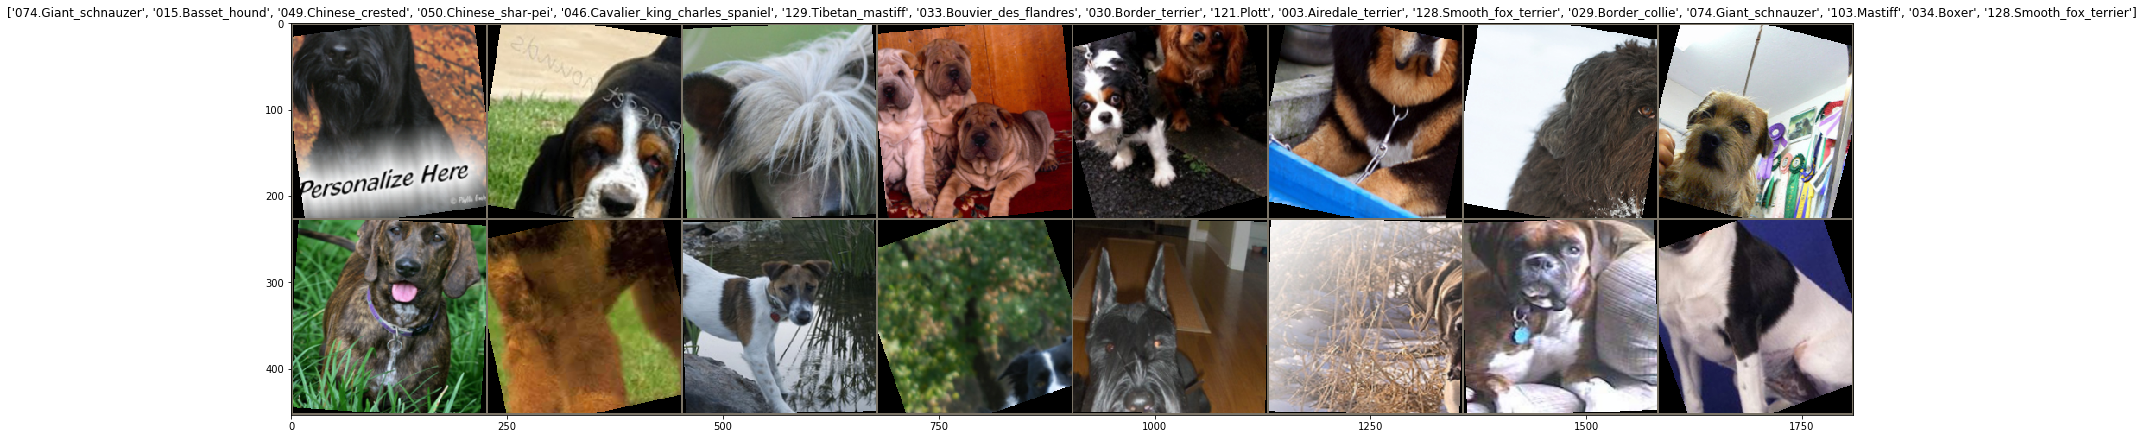

In [7]:
def vis_images(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(28, 43))
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(img_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

vis_images(out, title=[class_names[x] for x in classes])


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does our code resize the images (by cropping, stretching, etc)?  What size did we pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not? 

**Answer**:

    1. In training data I am resizing the image by randomly croping the image with 224 width and 224 height values and I picked 224 because it is also being suggested in many pretrained models.

    2. In data augmentation , I used horizontal flip and random rotation to train the model.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding = 1)
        self.conv5 = nn.Conv2d(512, 512, 3, padding = 1)
        
        self.ln1 = nn.Linear(512 * 7 * 7,512)
        self.ln2 = nn.Linear(512, 256)
        self.ln3 = nn.Linear(256, len(class_names) )
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        
        
        ## Define layers of a CNN
    
    def forward(self, x):
        ## Define forward behavior
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        x = x.view(-1, 512 * 7 * 7)
        
        x = F.relu(self.ln1(x))
        x = self.dropout(x) 
        x = F.relu(self.ln2(x))
        x = self.dropout(x) 
        x = self.ln3(x)
        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

* I have Implemented the CNN architecture with 5 Convolutional Layers and 3 Fullyconnected layers, I have also used dropout to reduce the overfitness during the training time. 

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below. 

In [20]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.001, momentum=0.9 )

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            
            optimizer.zero_grad()
            
            output = model.forward(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss += loss.item()
            if batch_idx % 40 ==0 :
                print(f" \rTraining {batch_idx+1}/{len(loaders['train'])} batche(s) Done ..." , end="" )
            
        train_loss = (1 / len(loaders["train"])) * train_loss
        print(f"Training Done")
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            torch.no_grad()
            
            out = model.forward(data)
            loss = criterion(out, target)
            valid_loss += loss.item()
            if batch_idx % 10 ==0 :
                print(f" \rValidation {batch_idx+1}/{len(loaders['valid'])} batche(s) Done ...", end="")
            
        valid_loss = (1 / len(loaders["valid"])) * valid_loss
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_loss = 0
        
        if valid_loss < valid_loss_min:
            print(f" Valid loss decreaced from {valid_loss_min:.2f} to {valid_loss:.2f} ... ")
            print(f" Saving the model ... ")
            valid_loss_min = valid_loss
            state = {
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
            }
            torch.save(state , save_path)
        print(f" {epoch}/{n_epochs} epochs Done ... ")
    # return trained model
    return model




In [ ]:
scratch_model_file = "models/model_scratch.pt"

if os.path.isfile(scratch_model):
    scratch_model = torch.load(scratch_model_file)
    model_scratch.load_state_dict(scratch_model["state_dict"])
    optimizer_scratch.load_state_dict(scratch_model["optimizer"])
    print(f" continuing the training model ......")

# train the model
model_scratch = train(100, img_dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, scratch_model_file)


 continuing the training model ......
Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 batche(s) Done ...    Epoch: 1 	Training Loss: 3.934077 	Validation Loss: 3.743879
 Valid loss decreaced from inf to 3.74 ... 
 Saving the model ... 
 1/100 epochs Done ... 
Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 batche(s) Done ...    Epoch: 2 	Training Loss: 3.908916 	Validation Loss: 3.694675
 Valid loss decreaced from 3.74 to 3.69 ... 
 Saving the model ... 
 2/100 epochs Done ... 
Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 batche(s) Done ...    Epoch: 3 	Training Loss: 3.890235 	Validation Loss: 3.692177
 Valid loss decreaced from 3.69 to 3.69 ... 
 Saving the model ... 
 3/100 epochs Done ... 
Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 batche(s) Done ...Epoch: 4 	Training Loss: 3.849223 	Validation Loss: 3.674671
 Valid loss decreaced from 3.69 to 3.67 ... 
 Saving the model 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

###### Test results on scratch model

    Test Loss: 3.396731

    Test Accuracy: 16% (138/836)

In [45]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(scratch_model_file)["state_dict"])

# call test function    
test(img_dataloaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.396731


Test Accuracy: 16% (138/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

###  Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`. 

In [12]:
import torchvision.models as models
import torch.nn as nn
 

model_transfer = models.resnet50(pretrained=True)

# freeze all model parameters
for param in model_transfer.parameters():
    param.requires_grad = False

# new final layer with 133 classes
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = torch.nn.Linear(num_ftrs, 133)

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem. 

__Answer:__ 

* To achieve the final CNN architecture, I have downloaded the pretrained ResNet50 models which have all the final parameters and set require gradient to False , because we are not going to train whole network again, to get the classes from 1 to 133 , I have replace the last fc layer with new linear fc with output features as `133` and finally convert it to the `cuda` type. 

###  Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below. 

In [15]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001, momentum=0.9)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`. 

In [38]:
transfer_model_file = "models/model_transfer.pt"

if os.path.isfile(transfer_model_file):
    transfer_model = torch.load(transfer_model_file)
    model_transfer.load_state_dict(transfer_model["state_dict"])
    optimizer_transfer.load_state_dict(transfer_model["optimizer"])

# train the model
model_transfer = train(100, img_dataloaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, transfer_model_file)



Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 batche(s) Done ...    Epoch: 1 	Training Loss: 0.928924 	Validation Loss: 0.387824
 Valid loss decreaced from inf to 0.39 ... 
 Saving the model ... 
 1/100 epochs Done ... 
Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 batche(s) Done ...    Epoch: 2 	Training Loss: 0.916208 	Validation Loss: 0.392773
 2/100 epochs Done ... 
Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 batche(s) Done ...    Epoch: 3 	Training Loss: 0.906214 	Validation Loss: 0.383503
 Valid loss decreaced from 0.39 to 0.38 ... 
 Saving the model ... 
 3/100 epochs Done ... 
Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 batche(s) Done ...Epoch: 4 	Training Loss: 0.889467 	Validation Loss: 0.377067
 Valid loss decreaced from 0.38 to 0.38 ... 
 Saving the model ... 
 4/100 epochs Done ... 
Training 401/418 batche(s) Done ...        Training Done
Validation 51/53 bat

<All keys matched successfully>

###  Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%. 

##### Test result on transfer model
    Test Loss: 0.354656
    Test Accuracy: 88% (743/836)

In [21]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(transfer_model_file)["state_dict"])

test(img_dataloaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.354656


Test Accuracy: 88% (743/836)


###  Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.   

In [25]:


# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in img_datasets['train'].classes]


def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    image = Image.open(img_path).convert('RGB')

    preprocess = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

    img_tensor = preprocess(image)
    img_tensor = img_tensor.unsqueeze(0)
    
    model_transfer.eval()
    with torch.no_grad():
        pred_prob = model_transfer(img_tensor.to(device))
        pred_class = pred_prob.argmax(dim=1).item()
    
    return class_names[pred_class]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm 

In [26]:


def run_app(img_path):
    
    plt.imshow(Image.open(img_path))
    plt.show()
    if face_detector(img_path):
        print(f" Hello human!")
        print(f" You look like a ... ")
        print(f" {predict_breed_transfer(img_path)} ")
    elif dog_detector(img_path):
        print(f" Hello Doggy!") 
        print(f" {predict_breed_transfer(img_path)} ")
    else:
        print(f" Couldn't find any human face or dog!! ")
    print(f"==========================================")
    print("  ")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm. 

__Answer:__ (Three possible points for improvement)

##### The output has around 88% accuracy on given test data, It is atlease good than I expected.
1. Get more Data of all the different types of breed and also can try different types of data augmentation transformers.
2. Modifications in Neural Network Architecture like adding batch normalization, more convolutional layers , adjusting dropout percentage etc.
3. Hyper parameter tuning like tweaking the values of learning rate , momentum, batchsize, epochs etc.

Actual label is Emanuel_Ginobili_0002


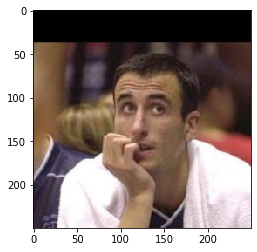

 Hello human!
 You look like a ... 
 Dogue de bordeaux 
  
Actual label is Emanuel_Ginobili_0004


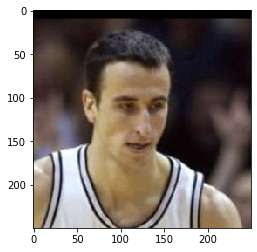

 Hello human!
 You look like a ... 
 Chinese shar-pei 
  
Actual label is Emanuel_Ginobili_0003


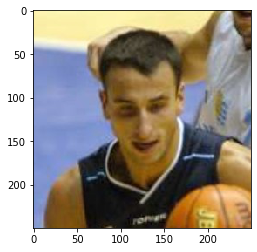

 Hello human!
 You look like a ... 
 Dachshund 
  
Actual label is German_pinscher_04843


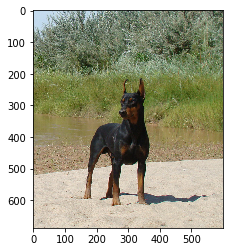

 Hello Doggy!
 Doberman pinscher 
  
Actual label is German_pinscher_04838


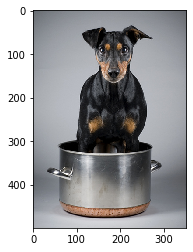

 Hello Doggy!
 German pinscher 
  
Actual label is Beauceron_01319


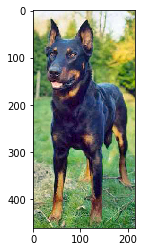

 Hello Doggy!
 Beauceron 
  


In [52]:
## suggested code, below
for file in np.hstack((human_files[10:13], dog_files[10:13])):
    actual_label = file.split("/")[-1][:-4]
    print(f"Actual label is {actual_label}")
    run_app(file)

# Testing Kaggle Data 

  You can Download the data from https://www.kaggle.com/c/dog-breed-identification/data

In [22]:
import pandas as pd

test_images = glob("kaggle_data/train/*")
labels = pd.read_csv("kaggle_data/labels.csv")

Actual label is standard_poodle


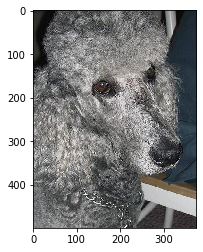

 Hello Doggy!
 Poodle 
  
Actual label is german_shepherd


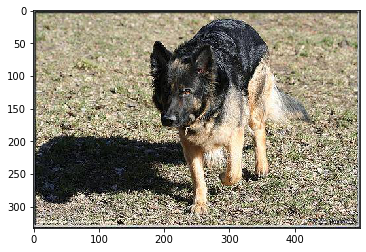

 Hello Doggy!
 German shepherd dog 
  
Actual label is siberian_husky


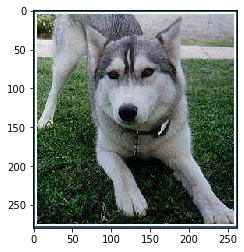

 Hello Doggy!
 Alaskan malamute 
  
Actual label is papillon


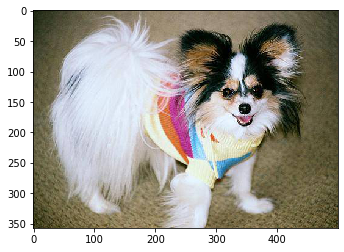

 Hello Doggy!
 Papillon 
  
Actual label is bernese_mountain_dog


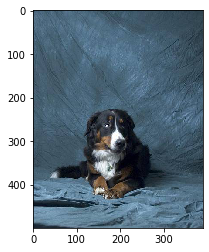

 Hello Doggy!
 Bernese mountain dog 
  
Actual label is bedlington_terrier


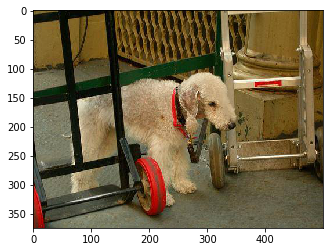

 Hello Doggy!
 Bedlington terrier 
  


In [43]:
for file_path in test_images[10:16]:
    actual_label = labels.loc[labels.id == file_path.split("/")[-1][:-4],"breed"].item()
    print(f"Actual label is {actual_label}")
    run_app(file_path)

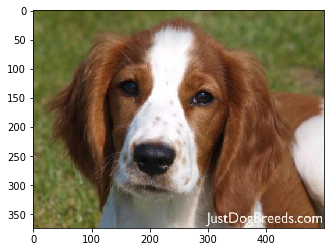

 Hello Doggy!
 Irish red and white setter 
  


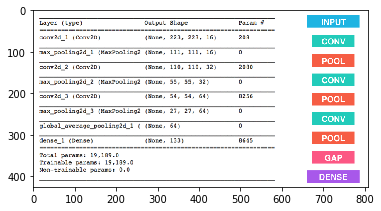

 Couldn't find any human face or dog!! 
  


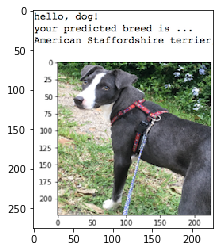

 Hello Doggy!
 Greyhound 
  


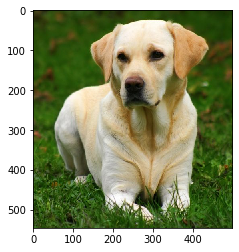

 Hello Doggy!
 Labrador retriever 
  


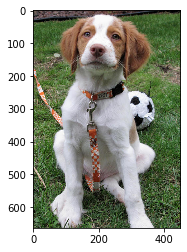

 Hello Doggy!
 Brittany 
  


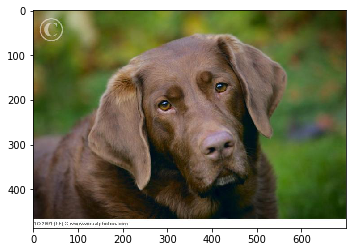

 Hello Doggy!
 Labrador retriever 
  


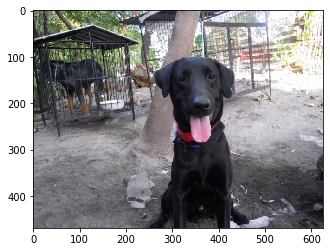

 Hello Doggy!
 Labrador retriever 
  


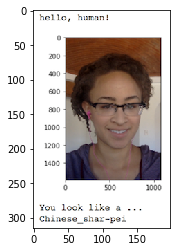

 Hello human!
 You look like a ... 
 Chinese crested 
  


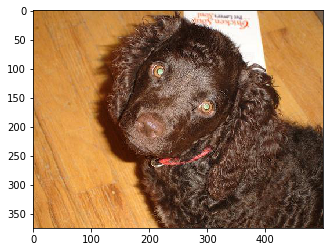

 Hello Doggy!
 Curly-coated retriever 
  


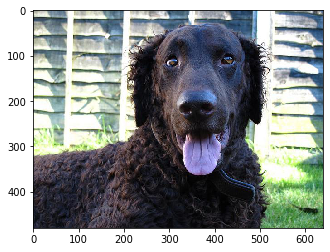

 Hello Doggy!
 Curly-coated retriever 
  


In [44]:
import numpy as np
from glob import glob

# load filenames
files = np.array(glob("images/*"))
for file_path in files:
    run_app(file_path)